# Visualise nominal GDP for European countries in billion $

### Purpose: 
* show how to use geopandas and geoplot and to visualise a certain quantity (here GDP) per country
* web scraping part has not been included but would be fun to show as well

### Modules

In [8]:
import numpy as np
import pandas as pd

import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point

import matplotlib.pyplot as plt
import geoplot.crs as gcrs
import geoplot as gplt

import seaborn as sns
sns.set_style('whitegrid')

import helper_functions

### Data import and wranging part

Mapping of countries and their capitals:

In [3]:
european_countries_capitals = pd.read_csv('data/european_countries_capitals.txt',
                                         sep='--', engine='python')

european_countries_capitals = helper_functions.format_columns(european_countries_capitals)

european_countries_capitals['capital'] = european_countries_capitals['capital'].str.strip()

european_countries_capitals['country'] = european_countries_capitals['country'].str.strip()

European countries border information merged with capital information from above to just keep the country names:

In [4]:
european_areas = gpd.read_file('data/Europe_borders.shp')

european_areas['TZID'] = european_areas['TZID'].str.replace('Europe/', '')

european_areas.rename(columns = {'TZID':'capital'}, inplace = True)

geometry = european_areas['geometry']

european_areas = helper_functions.format_columns(european_areas)

european_areas['capital'] = european_areas['capital'].str.strip()

european_areas = european_areas.merge(european_countries_capitals, on='capital', how='inner')

european_areas.drop(columns=['geometry'], inplace=True)

european_areas['geometry'] = geometry

Source: [List_of_sovereign_states_in_Europe_by_GDP_(nominal)](https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(nominal))

In [5]:
european_countries_gdp = pd.read_csv('data/european_countries_gdp.txt',
                                         sep='\t', engine='python')

european_countries_gdp.drop(columns=['2018 Rank'], inplace=True)

european_countries_gdp.rename(columns = {'2018[2]':'2018'}, inplace = True)

european_countries_gdp = helper_functions.format_columns(european_countries_gdp)

european_countries_gdp['country'] = european_countries_gdp['country'].str.strip()

Calculate relative GDP and merge all information together:

In [6]:
europe = european_areas.merge(european_countries_gdp, on='country', how='inner')

europe['2018'] = europe['2018'].str.replace(',','')

europe['2018'] = europe['2018'].astype('float')

total_gdp_2018 = europe['2018'].sum()

europe = europe.reset_index()

europe.rename(columns = {'index':'id'}, inplace = True)

gdp_per_country = europe[['country', '2018']].groupby(['country']).sum()
gdp_total = europe[['country', '2018']].groupby(['country']).sum().sum()
gdp_total = int(round(gdp_total.values[0], 0))
gdp_per_country = gdp_per_country.reset_index()
gdp_per_country.rename(columns = {'2018':'gdp'}, inplace = True)
gdp_per_country['gdp'] = round(gdp_per_country['gdp'], 0)
gdp_per_country['gdp'] = gdp_per_country['gdp'].astype(float)
gdp_per_country['gdp_relative'] = gdp_per_country['gdp'] / gdp_total
gdp_per_country['gdp_relative'] = round(gdp_per_country['gdp_relative'] * 100, 2)

europe = europe.merge(gdp_per_country, on='country', how='inner')

and finally the visualisation:

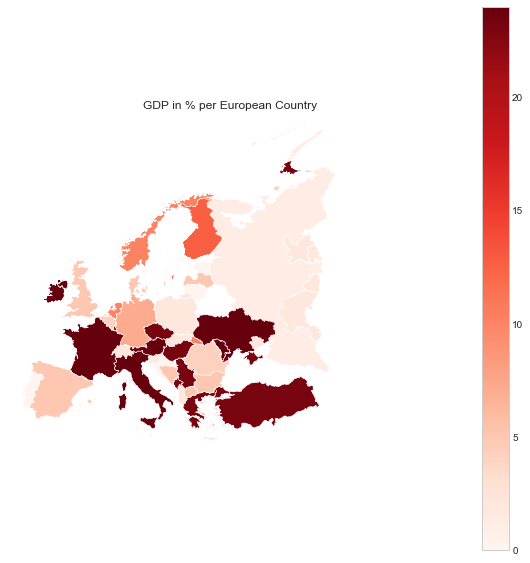

In [7]:
gplt.choropleth(europe, hue=europe['gdp_relative'],
                projection=gcrs.AlbersEqualArea(),
                cmap='Reds',
                linewidth=0.5,
                edgecolor='white',
                k=None,
                legend=True,
                figsize=(10,10))
plt.title('GDP in % per European Country')
plt.savefig('data/europe_relative_gdp.png', bbox_inches='tight', pad_inches=0.1)